In [2]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import fastf1
fastf1.Cache.enable_cache('/Users/nooralindeflaten/f1_ML_predictor/data/cache')  # Enable cache for faster data loading
# 🛞 1. Load the wrapped model + info


# ANALYSIS PLAN
We should find a way to see what causes lap-time to increase or decrease. 
Currently working on the tyre model. 


### TYRES
- Basic degradation, we have this, but some issues. We'll find a way to fix the rainfall, and add traffic data.
    Later maybe we'll look at the track's or driver's speed, conditions on a deeper level, but maybe we need to build some of the other stuff first. We'll also want the traffic model to handle varying placements etc. 

### CIRCUIT
    The circuit corner analysis and sector analysis we did gives us an idea on how to calculate the entry-exit.
    I made a small gear-shift across track plot etc. We'll need to create a model for maybe "optimal racing line"?
    Maybe we need to find out more specifics here.

### DRIVER
    the driver profile should use gear, rpm, performance whatever to see how the driver is "best" maybe what track, conditions team?

### TEAM
    We'll need historic data on the drivers, we could analyse which driverstyles has fit their cars over their years. Maybe this could give us values or something we can add to strategy

## OVERALL PLAN
So we need our models, profiles in whatever way we choose.
When we have all this ready we can use our analysis to train models that will adapt to "live-timing-input"
Let's say we create models or let's call it we create a race engineer. This engineer get's data based on session. After we have trained our
models these seperated shouldn't create bias on predictions in the first place hopefully. 
If our race-strategist get's data from free-practice and quali as well as weather, track, team, driver.
It will adapt to the current situation. So maybe historical data vs seasonal data on driver behaviour, results. Seasonal vs historical data on the track/tyre/weather conditions, as well as the input the race engineer just got (this may not need to be specific or seperated, but might be useful to have a good structure on division of data)

when all of this is ready we need to also consider the combination of things because a model may classify team-driver-style combination based on what we have but it should be able to filter out if let's say the driver had bad results from the prior team, but has had a good season now this is because of A->B->C. There's a lot of combinations we could use to get our model most optimal.

Then as you can see we have ALOT of stuff, I want the models to be so good that if we go (models made) -> practice input -> quali input = race strategy. That when our fake race starts it will analyse the driver behaviour BY THE SECOND OR EVEN MILISECOND. So when we see our driver breaks heavily here he should have sped up at this and this position or else he'll loose time. When we (or i mean race strategist) can pick up enough info it can predict that even tho our "base model" was supposed to pit now it seems the driver is affected by other factors so we need to pit earlier. Since we don't actually have a driver we'll need to maybe create a "random driver model" that basically is the driver-profile and simulates "random" driving in our fake race, so we can see how our model-driver adapts. Basically we'll need a fake strategist and driver.

After this we'll know how a model should react if a driver reacts. so the combination of alllll of these things will make our models predict in real-time what the best course of action should be strategy wise. (we could also see how much the strategy vs driver was faulty)

we'll then need to maybe create some sort of tree structure? A model that can also tell us what's not happening or i don't know. When our models are good enough. I mean good good. We can start finding FIA rules and upgrades as well. 

Maybe we still stay in monaco? for testing? Also I need to fins out what the statuse's in track and race_control means

In [6]:
import pandas as pd
from tire_model import TirePerformanceModel
from sklearn.model_selection import train_test_split

# --- Load merged Monaco laps with weather and gaps ---
df = pd.read_pickle('/Users/nooralindeflaten/f1_ML_predictor/data/processed/laps_with_weather_gaps_monaco.pkl')

# --- Filter for Practice and Quali sessions only ---

# --- Drop NaNs in critical columns ---
df = df.dropna(subset=['LapTime', 'TyreLife', 'Compound', 'TrackTemp', 'AirTemp', 'Pressure'])

# --- Map old special compounds (Hypersoft, Ultrasoft, Supersoft) into Soft ---
def map_compound(compound):
    if compound in ['HYPERSOFT', 'ULTRASOFT', 'SUPERSOFT', 'SOFT']:
        return 'SOFT'
    elif compound in ['MEDIUM']:
        return 'MEDIUM'
    elif compound in ['HARD']:
        return 'HARD'
    elif compound in ['INTERMEDIATE']:
        return 'INTERMEDIATE'
    elif compound in ['WET']:
        return 'WET'
    else:
        return compound  # fallback

# Apply mapping
df['MappedCompound'] = df['Compound'].apply(map_compound)

# --- One-hot encode new MappedCompound ---
df = pd.get_dummies(df, columns=['MappedCompound'])

# --- Define features and target ---
feature_cols = ['TyreLife', 'TrackTemp', 'AirTemp', 'Pressure'] + \
               [col for col in df.columns if col.startswith('MappedCompound_')]

X = df[feature_cols]
y = df['LapTime']

print(f"✅ Feature matrix ready: {X.shape}, target ready: {y.shape}")

# --- Train/Test split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train Tire Performance Model ---
model = TirePerformanceModel(degree=2)
model.fit(X_train, y_train)

# --- Validation ---
score = model.pipeline.score(X_val, y_val)
print(f"🔍 Tire Model R² on validation set: {score:.4f}")

# --- Save model ---
model.save('/Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/tire_model_poly2_mapped.pkl')

print("✅ Tire model saved: tire_model_poly2_mapped.pkl")


✅ Feature matrix ready: (16454, 9), target ready: (16454,)
🔍 Tire Model R² on validation set: 0.1806
✅ Model saved to /Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/tire_model_poly2_mapped.pkl
✅ Tire model saved: tire_model_poly2_mapped.pkl


## Tire and Trafic

- First we use our basic model
- Filter races and compare to predictions

In [3]:
from tire_model import TirePerformanceModel

# Load tire model
tire_model = TirePerformanceModel.load('/Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/tire_model_poly2_mapped.pkl')

import pandas as pd

# Load full Monaco data
race_data = pd.read_pickle('/Users/nooralindeflaten/f1_ML_predictor/data/processed/laps_with_weather_gaps_monaco.pkl')

# Filter only Race sessions
race_data = race_data[race_data['session_type'] == 'R']

# One-hot encode Compound
# --- Map Compounds on Race data too ---
def map_compound(compound):
    if compound in ['HYPERSOFT', 'ULTRASOFT', 'SUPERSOFT', 'SOFT']:
        return 'SOFT'
    elif compound == 'MEDIUM':
        return 'MEDIUM'
    elif compound == 'HARD':
        return 'HARD'
    else:
        return compound

race_data['MappedCompound'] = race_data['Compound'].apply(map_compound)

# --- One-hot encode mapped compound ---
compounds = pd.get_dummies(race_data['MappedCompound'], prefix='MappedCompound')

# Match feature columns
feature_cols = ['TyreLife', 'TrackTemp', 'AirTemp', 'Pressure'] + [col for col in compounds.columns]

# Build X_race
X_race = pd.concat([
    race_data[['TyreLife', 'TrackTemp', 'AirTemp', 'Pressure']],
    compounds
], axis=1)

# Only keep columns the model was trained with
X_race = X_race.reindex(columns=tire_model.feature_names, fill_value=0)

print(f"✅ Race data ready for prediction: {X_race.shape}")
# Predict LapTimes
race_data['PredictedLapTime'] = tire_model.predict(X_race)
race_data['DeltaLapTime'] = race_data['LapTime'] - race_data['PredictedLapTime']


✅ Model loaded from /Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/tire_model_poly2_mapped.pkl
✅ Race data ready for prediction: (7000, 7)


In [33]:
race_data[['GapToLeader','IntervalToPositionAhead','Position_y']]

,GapToLeader,IntervalToPositionAhead,Position_y
9454,+1.135,+1.135,2
9455,+1.447,+1.447,2
9456,+1.725,+1.725,2
9457,+1.417,+1.417,2
9458,+1.695,+1.695,2
...,...,...,...
16449,1 L,+8.898,10
16450,1 L,+10.574,10
16451,1 L,+11.288,10
16452,1 L,+12.153,10


✅ Clean race laps after filtering: 4714


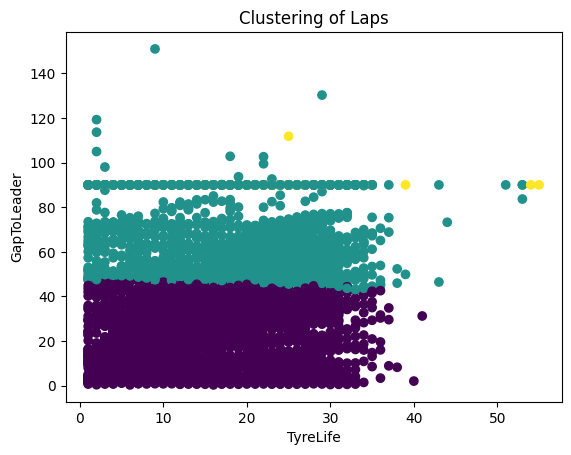

In [5]:
# Already calculated DeltaLapTime before
# Keep only reasonable deltas
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def clean_gap_value(val):
    if isinstance(val, str):
        if 'L' in val:
            return 90.0  # 1 lap = about 90 seconds in Monaco
        val = val.replace('+', '')
    try:
        return float(val)
    except:
        return None  # fallback if still invalid

# Apply cleaning
race_data['GapToLeader'] = race_data['GapToLeader'].apply(clean_gap_value)
race_data['IntervalToPositionAhead'] = race_data['IntervalToPositionAhead'].apply(clean_gap_value)

# Drop any rows where Gap or Interval still NaN after cleaning
race_data = race_data.dropna(subset=['GapToLeader', 'IntervalToPositionAhead'])


race_data_filtered = race_data[
    (race_data['DeltaLapTime'] > -20) & 
    (race_data['DeltaLapTime'] < 20) 
].copy()

print(f"✅ Clean race laps after filtering: {race_data_filtered.shape[0]}")

# Features
X_traffic = race_data_filtered[['GapToLeader', 'IntervalToPositionAhead']]

# Target
y_traffic = race_data_filtered['DeltaLapTime']

features_for_clustering = race_data_filtered[['TyreLife', 'GapToLeader', 'IntervalToPositionAhead']]

# Fill NaNs safely
features_for_clustering = features_for_clustering.fillna(0)

# Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
race_data_filtered['Cluster'] = kmeans.fit_predict(features_for_clustering)

# Visualize
plt.scatter(race_data_filtered['TyreLife'], race_data_filtered['GapToLeader'], c=race_data_filtered['Cluster'])
plt.xlabel('TyreLife')
plt.ylabel('GapToLeader')
plt.title('Clustering of Laps')
plt.show()



## First basic Tyre Model for degregation on weather, laptime, etc.

✅ Model loaded. Degree: 2, Features: ['TyreLife', 'TrackTemp', 'AirTemp', 'Pressure', 'Compound_HARD', 'Compound_HYPERSOFT', 'Compound_MEDIUM', 'Compound_SOFT', 'Compound_SUPERSOFT', 'Compound_ULTRASOFT']
Active compound inputs:
   TyreLife  TrackTemp  AirTemp  Pressure  Compound_MEDIUM
0         1       47.4     26.7    1003.5                1
Active compound inputs:
   TyreLife  TrackTemp  AirTemp  Pressure  Compound_MEDIUM
0         2       47.4     26.7    1003.5                1
Active compound inputs:
   TyreLife  TrackTemp  AirTemp  Pressure  Compound_MEDIUM
0         3       47.4     26.7    1003.5                1
Active compound inputs:
   TyreLife  TrackTemp  AirTemp  Pressure  Compound_MEDIUM
0         4       47.4     26.7    1003.5                1
Active compound inputs:
   TyreLife  TrackTemp  AirTemp  Pressure  Compound_MEDIUM
0         5       47.4     26.7    1003.5                1
Active compound inputs:
   TyreLife  TrackTemp  AirTemp  Pressure  Compound_MEDIUM
0 

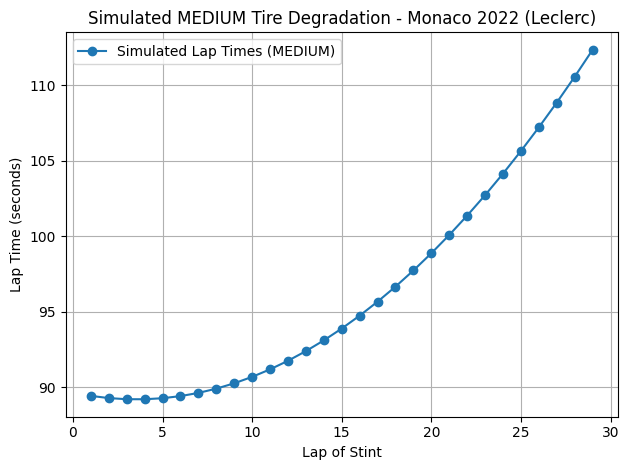

In [12]:
model_data = joblib.load("/Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/tire_model_poly2.pkl")
model = model_data['model']
feature_names = model_data['feature_names']
degree = model_data['degree']

print(f"✅ Model loaded. Degree: {degree}, Features: {feature_names}")

# 📚 2. Load Monaco lap data
df = pd.read_pickle("/Users/nooralindeflaten/f1_ML_predictor/data/processed/laps_with_weather_monaco.pkl")


# 🎯 3. Pick driver + session to analyze (Leclerc 2022 Q)
subset = df[
    (df['Driver'] == 'LEC') &
    (df['year'] == 2022) &
    (df['session_type'] == 'Q') &
    (df['LapTime'] > 0)
].copy()

# 🌡️ 4. Calculate median weather from real session
weather_inputs = {
    "TrackTemp": subset["TrackTemp"].median(),
    "AirTemp": subset["AirTemp"].median(),
    "Pressure": subset["Pressure"].median()
}

# ⚙️ 5. Set compound to simulate
compound = "MEDIUM"

# 🔥 6. Build one-hot encoding for compounds
compound_cols = [col for col in feature_names if col.startswith("Compound_")]
compound_onehots = {col: (1 if col.lower().endswith(compound.lower()) else 0) for col in compound_cols}

# 📈 7. Simulate 15-lap stint
simulated_times = []
for lap_life in range(1, 30):
    features = {
        "TyreLife": lap_life,
        **weather_inputs,
        **compound_onehots
    }

    # Fill missing features with 0
    for col in feature_names:
        if col not in features:
            features[col] = 0

    X = pd.DataFrame([features])[feature_names]
    print("Active compound inputs:")
    print(X.loc[:, X.iloc[0] != 0])

    lap_time = model.predict(X)[0]
    simulated_times.append(lap_time)

# 🖼️ 8. Plot simulated degradation
plt.plot(range(1, 30), simulated_times, marker='o', label=f'Simulated Lap Times ({compound})')
plt.xlabel('Lap of Stint')
plt.ylabel('Lap Time (seconds)')
plt.title(f'Simulated {compound} Tire Degradation - Monaco 2022 (Leclerc)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
